# Notebook 07: End-to-End Fraud Detection Pipeline

This merged notebook unifies the end-to-end training workflow (fusion optimisation, RAG assets, Docker export) with the production inference pipeline used to score transactions and generate reports. Run the cells sequentially to reproduce training, evaluation, explainability, and deployment artifacts in both local and Kaggle environments.

## Pipeline Roadmap
- Detect runtime environment and configure read/write paths
- Validate processed datasets and load GNN/LSTM embeddings
- Train and select the best fusion architecture
- Build a lightweight RAG index and export FastAPI + Docker assets
- Instantiate the production pipeline for inference, evaluation, and reporting

In [1]:
# Cell 1: Core imports and environment diagnostics
import os
import sys
import json
import pickle
import random
import warnings
import time
import gc
import shutil
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast

try:
    import torch_geometric
    from torch_geometric.data import Data
    from torch_geometric.loader import NeighborLoader
    from torch_geometric.nn import GATv2Conv, GCNConv, SAGEConv
    TORCH_GEOMETRIC_AVAILABLE = True
except ImportError:
    TORCH_GEOMETRIC_AVAILABLE = False

from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

RUNNING_ON_KAGGLE = bool(os.environ.get('KAGGLE_KERNEL_RUN_TYPE'))
print('=' * 90)
print(' ' * 20 + 'FLAG-FINANCE END-TO-END PIPELINE')
print('=' * 90)
print(f"\n🐍 Python version: {sys.version}")
print(f"📦 PyTorch: {torch.__version__}")
print(f"📦 Torch Geometric: {getattr(torch_geometric, '__version__', 'unavailable')}")
print(f"🔧 CUDA available: {torch.cuda.is_available()}")
print(f"📁 Environment: {'Kaggle' if RUNNING_ON_KAGGLE else 'Local'}")

if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

def seed_all(seed: int = 42) -> None:
    """Seed all common libraries for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_all(42)

C:\Users\youss\Downloads\Flag_finance\rag_venv\Lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: C:\Users\youss\Downloads\Flag_finance\rag_venv\Lib\site-packages\torch_scatter\_version_cpu.pyd
  import torch_geometric.typing
C:\Users\youss\Downloads\Flag_finance\rag_venv\Lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: Could not load this library: C:\Users\youss\Downloads\Flag_finance\rag_venv\Lib\site-packages\torch_cluster\_version_cpu.pyd
  import torch_geometric.typing
C:\Users\youss\Downloads\Flag_finance\rag_venv\Lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: Could not load this library: C:\Users\youss\Downloads\Flag_finance\rag_venv\Lib\site-packages\torch_spl

                    FLAG-FINANCE END-TO-END PIPELINE

🐍 Python version: 3.12.4 (tags/v3.12.4:8e8a4ba, Jun  6 2024, 19:30:16) [MSC v.1940 64 bit (AMD64)]
📦 PyTorch: 2.9.0+cpu
📦 Torch Geometric: 2.7.0
🔧 CUDA available: False
📁 Environment: Local


In [2]:
# Cell 2: Path configuration (handles Kaggle & local)
print('\n📁 Configuring project paths...')

if RUNNING_ON_KAGGLE:
    BASE_PATH = Path('/kaggle/input/flag-finance').resolve()
    WORKING_ROOT = Path('/kaggle/working').resolve()
else:
    WORKING_ROOT = Path('..').resolve()
    BASE_PATH = WORKING_ROOT

DATA_ROOT = BASE_PATH if RUNNING_ON_KAGGLE else BASE_PATH / 'data'
PROCESSED_PATH = DATA_ROOT / 'processed'
if RUNNING_ON_KAGGLE:
    nested_processed = PROCESSED_PATH / 'processed'
    if nested_processed.exists():
        PROCESSED_PATH = nested_processed
RAW_PATH = DATA_ROOT / 'raw'
SNAPSHOT_MODELS_PATH = DATA_ROOT / 'models'
SNAPSHOT_RESULTS_PATH = DATA_ROOT / 'results'
SNAPSHOT_GRAPHS_PATH = DATA_ROOT / 'graphs'
SNAPSHOT_RAG_PATH = DATA_ROOT / 'rag_output'

MODELS_PATH = WORKING_ROOT / 'models'
RESULTS_PATH = WORKING_ROOT / 'results'
GRAPHS_PATH = WORKING_ROOT / 'graphs'
PIPELINE_OUTPUT = WORKING_ROOT / 'pipeline_output'
OUTPUT_PATH = WORKING_ROOT / 'rag_output'
VECTOR_DB_PATH = WORKING_ROOT / 'vector_db'
SERVICE_ROOT = WORKING_ROOT / 'e2e_pipeline'

for directory in [MODELS_PATH, RESULTS_PATH, GRAPHS_PATH, PIPELINE_OUTPUT, OUTPUT_PATH, VECTOR_DB_PATH, SERVICE_ROOT]:
    directory.mkdir(parents=True, exist_ok=True)

INPUT_RESULTS_PATH = SNAPSHOT_RESULTS_PATH
INPUT_MODELS_PATH = SNAPSHOT_MODELS_PATH
INPUT_GRAPHS_PATH = SNAPSHOT_GRAPHS_PATH

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('   Data root (read-only):', DATA_ROOT)
print('   Processed data       :', PROCESSED_PATH)
print('   Raw data             :', RAW_PATH)
print('   Snapshot models      :', SNAPSHOT_MODELS_PATH)
print('   Snapshot results     :', SNAPSHOT_RESULTS_PATH)
print('   Snapshot graphs      :', SNAPSHOT_GRAPHS_PATH)
print('   Working root         :', WORKING_ROOT)
print('   Writable models      :', MODELS_PATH)
print('   Writable results     :', RESULTS_PATH)
print('   Pipeline output      :', PIPELINE_OUTPUT)
print('   RAG output           :', OUTPUT_PATH)
print('   Vector DB cache      :', VECTOR_DB_PATH)
print('   Service bundle root  :', SERVICE_ROOT)
print(f'\n🔧 Active torch device: {device}')


📁 Configuring project paths...
   Data root (read-only): C:\Users\youss\Downloads\Flag_finance\data
   Processed data       : C:\Users\youss\Downloads\Flag_finance\data\processed
   Raw data             : C:\Users\youss\Downloads\Flag_finance\data\raw
   Snapshot models      : C:\Users\youss\Downloads\Flag_finance\data\models
   Snapshot results     : C:\Users\youss\Downloads\Flag_finance\data\results
   Snapshot graphs      : C:\Users\youss\Downloads\Flag_finance\data\graphs
   Working root         : C:\Users\youss\Downloads\Flag_finance
   Writable models      : C:\Users\youss\Downloads\Flag_finance\models
   Writable results     : C:\Users\youss\Downloads\Flag_finance\results
   Pipeline output      : C:\Users\youss\Downloads\Flag_finance\pipeline_output
   RAG output           : C:\Users\youss\Downloads\Flag_finance\rag_output
   Vector DB cache      : C:\Users\youss\Downloads\Flag_finance\vector_db
   Service bundle root  : C:\Users\youss\Downloads\Flag_finance\e2e_pipeline

🔧 Ac

## Validate Processed Transactions

In [3]:
# Cell 3: Load processed PaySim transactions
processed_candidates = [
    PROCESSED_PATH / 'paysim_sample_enhanced.csv',
    PROCESSED_PATH / 'paysim_data_enhanced.csv',
    PROCESSED_PATH / 'processed' / 'paysim_sample_enhanced.csv',
    PROCESSED_PATH / 'processed' / 'paysim_data_enhanced.csv',
    WORKING_ROOT / 'processed' / 'paysim_sample_enhanced.csv',
    WORKING_ROOT / 'processed' / 'paysim_data_enhanced.csv'
]
data_file = next((path for path in processed_candidates if path.exists()), None)

if not data_file:
    raise FileNotFoundError(
        'Processed transaction CSV not found. Run preprocessing steps before launching the pipeline.\n'
        f'Checked locations: {processed_candidates}'
    )

df = pd.read_csv(data_file)
print(f"✅ Loaded transactions: {data_file} | shape={df.shape}")
print(f"   Columns: {list(df.columns)}")

if 'is_weekend' not in df.columns:
    if 'day' in df.columns:
        df['is_weekend'] = df['day'].astype(int).isin([5, 6]).astype(int)
    else:
        df['is_weekend'] = 0

✅ Loaded transactions: C:\Users\youss\Downloads\Flag_finance\data\processed\paysim_sample_enhanced.csv | shape=(127252, 22)
   Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'balanceOrig_diff', 'balanceDest_diff', 'balance_error_orig', 'balance_error_dest', 'hour', 'day', 'is_night', 'amount_log', 'amount_sqrt', 'amount_zscore', 'amount_outlier']


## Load Precomputed GNN & LSTM Embeddings

In [4]:
# Cell 4: Resolve and load embedding snapshots
def locate_file(candidates: List[Path]) -> Optional[Path]:
    for candidate in candidates:
        if candidate.exists():
            return candidate
    return None

gnn_candidates = [
    PROCESSED_PATH / 'gnn_embeddings.pkl',
    PROCESSED_PATH / 'processed' / 'gnn_embeddings.pkl',
    INPUT_MODELS_PATH / 'gnn_embeddings.pkl',
    MODELS_PATH / 'gnn_embeddings.pkl',
    DATA_ROOT / 'gnn_embeddings.pkl'
]
lstm_candidates = [
    PROCESSED_PATH / 'lstm_embeddings.pkl',
    PROCESSED_PATH / 'processed' / 'lstm_embeddings.pkl',
    INPUT_MODELS_PATH / 'lstm_embeddings.pkl',
    MODELS_PATH / 'lstm_embeddings.pkl',
    DATA_ROOT / 'lstm_embeddings.pkl'
]

gnn_path = locate_file(gnn_candidates)
lstm_path = locate_file(lstm_candidates)

if not gnn_path or not lstm_path:
    raise FileNotFoundError(
        "Missing embeddings from Notebooks 03 & 04. Ensure gnn_embeddings.pkl and "
        "lstm_embeddings.pkl are available before running this notebook.\n"
        f"GNN candidates: {gnn_candidates}\nLSTM candidates: {lstm_candidates}"
    )

with open(gnn_path, 'rb') as g_file:
    gnn_embeddings_dict = pickle.load(g_file)
with open(lstm_path, 'rb') as l_file:
    lstm_embeddings_dict = pickle.load(l_file)

print('✅ Loaded embeddings:')
print('   GNN models :', list(gnn_embeddings_dict.keys()))
print('   LSTM models:', list(lstm_embeddings_dict.keys()))

PREFERRED_GNN = 'HybridGNN_L4_H320'
PREFERRED_LSTM = 'LSTM_CNN_Hybrid'

gnn_key = PREFERRED_GNN if PREFERRED_GNN in gnn_embeddings_dict else next(iter(gnn_embeddings_dict))
lstm_key = PREFERRED_LSTM if PREFERRED_LSTM in lstm_embeddings_dict else next(iter(lstm_embeddings_dict))

gnn_data = gnn_embeddings_dict[gnn_key]
lstm_data = lstm_embeddings_dict[lstm_key]

splits = ['train', 'val', 'test']
fusion_data: Dict[str, Dict[str, np.ndarray]] = {}
for split in splits:
    g_embeddings = gnn_data[split]['embeddings']
    l_embeddings = lstm_data[split]['embeddings']
    labels = gnn_data[split]['labels']
    min_len = min(len(g_embeddings), len(l_embeddings), len(labels))
    fusion_data[split] = {
        'gnn': g_embeddings[:min_len],
        'lstm': l_embeddings[:min_len],
        'y': labels[:min_len]
    }
    print(f"{split.upper():>5} → GNN {g_embeddings[:min_len].shape} | LSTM {l_embeddings[:min_len].shape} | y {labels[:min_len].shape}")

GNN_DIM = fusion_data['train']['gnn'].shape[1]
LSTM_DIM = fusion_data['train']['lstm'].shape[1]
print(f"Dims → GNN: {GNN_DIM} | LSTM: {LSTM_DIM} | SUM: {GNN_DIM + LSTM_DIM}")

✅ Loaded embeddings:
   GNN models : ['HybridGNN_L4_H320']
   LSTM models: ['BiLSTM_Attention', 'ResidualGRU', 'LSTM_CNN_Hybrid']
TRAIN → GNN (4498, 320) | LSTM (4498, 256) | y (4498,)
  VAL → GNN (1125, 320) | LSTM (1125, 256) | y (1125,)
 TEST → GNN (1406, 320) | LSTM (1406, 256) | y (1406,)
Dims → GNN: 320 | LSTM: 256 | SUM: 576


## Build Fusion Dataset & DataLoaders

In [5]:
# Cell 5: Dataset wrappers and data loaders for fusion training
class FusionDataset(Dataset):
    def __init__(self, g_embeddings: np.ndarray, l_embeddings: np.ndarray, labels: np.ndarray):
        self.g = torch.FloatTensor(g_embeddings)
        self.l = torch.FloatTensor(l_embeddings)
        self.y = torch.LongTensor(labels)

    def __len__(self) -> int:
        return len(self.y)

    def __getitem__(self, index: int):
        return self.g[index], self.l[index], self.y[index]

    def class_weights(self) -> torch.Tensor:
        counts = np.bincount(self.y.numpy(), minlength=2)
        counts = np.maximum(counts, 1)
        weights = 1.0 / counts
        weights = weights / weights.sum() * len(weights)
        return torch.FloatTensor(weights)

train_ds = FusionDataset(fusion_data['train']['gnn'], fusion_data['train']['lstm'], fusion_data['train']['y'])
val_ds = FusionDataset(fusion_data['val']['gnn'], fusion_data['val']['lstm'], fusion_data['val']['y'])
test_ds = FusionDataset(fusion_data['test']['gnn'], fusion_data['test']['lstm'], fusion_data['test']['y'])

BATCH_SIZE = 256
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print('✅ DataLoaders ready:')
print(f"   Train batches: {len(train_loader)} | Val batches: {len(val_loader)} | Test batches: {len(test_loader)}")

✅ DataLoaders ready:
   Train batches: 18 | Val batches: 5 | Test batches: 6


## Model Architectures (GNN, LSTM, Fusion Variants)

In [6]:
# Cell 6: Model definitions for downstream tasks
class HybridGNN(nn.Module):
    """Hybrid GCN + GraphSAGE + GAT architecture used in Notebook 03."""
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int, num_layers: int = 4, dropout: float = 0.4, gat_heads: int = 8):
        super().__init__()
        if not TORCH_GEOMETRIC_AVAILABLE:
            raise ImportError('torch_geometric is required for HybridGNN.')
        self.dropout = dropout

        self.input_proj = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.ReLU()
        )

        self.gcn_layers = nn.ModuleList()
        self.sage_layers = nn.ModuleList()
        self.gat_layers = nn.ModuleList()
        self.fusion_layers = nn.ModuleList()

        for layer_idx in range(num_layers):
            self.gcn_layers.append(GCNConv(hidden_channels, hidden_channels, improved=True))
            self.sage_layers.append(SAGEConv(hidden_channels, hidden_channels, normalize=True))
            heads = gat_heads if layer_idx < 2 else max(4, gat_heads // 2)
            self.gat_layers.append(GATv2Conv(hidden_channels, hidden_channels // heads, heads=heads, dropout=dropout, concat=True))
            self.fusion_layers.append(nn.Sequential(
                nn.Linear(hidden_channels * 3, hidden_channels),
                nn.LayerNorm(hidden_channels),
                nn.PReLU()
            ))

        self.classifier = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.BatchNorm1d(hidden_channels),
            nn.PReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.BatchNorm1d(hidden_channels // 2),
            nn.PReLU(),
            nn.Dropout(dropout * 0.8),
            nn.Linear(hidden_channels // 2, out_channels)
        )

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        x = self.input_proj(x)
        gcn_out = x
        sage_out = x
        gat_out = x

        for gcn, sage, gat, fusion in zip(self.gcn_layers, self.sage_layers, self.gat_layers, self.fusion_layers):
            gcn_residual, sage_residual, gat_residual = gcn_out, sage_out, gat_out

            gcn_out = F.relu(gcn(gcn_out, edge_index))
            sage_out = F.relu(sage(sage_out, edge_index))
            gat_out = F.elu(gat(gat_out, edge_index))

            gcn_out = F.dropout(gcn_out, p=self.dropout, training=self.training)
            sage_out = F.dropout(sage_out, p=self.dropout, training=self.training)
            gat_out = F.dropout(gat_out, p=self.dropout, training=self.training)

            fused = fusion(torch.cat([gcn_out, sage_out, gat_out], dim=1))
            gcn_out = fused + gcn_residual * 0.3
            sage_out = fused + sage_residual * 0.3
            gat_out = fused + gat_residual * 0.3

        return self.classifier(fused)

    def extract_embeddings(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        x = self.input_proj(x)
        gcn_out = x
        sage_out = x
        gat_out = x

        for gcn, sage, gat, fusion in zip(self.gcn_layers, self.sage_layers, self.gat_layers, self.fusion_layers):
            gcn_out = F.relu(gcn(gcn_out, edge_index))
            sage_out = F.relu(sage(sage_out, edge_index))
            gat_out = F.elu(gat(gat_out, edge_index))
            fused = fusion(torch.cat([gcn_out, sage_out, gat_out], dim=1))
            gcn_out = fused
            sage_out = fused
            gat_out = fused

        return fused

class LSTMCNN(nn.Module):
    """Hybrid LSTM + multi-kernel CNN sequence encoder from Notebook 04."""
    def __init__(self, input_size: int, hidden_size: int = 128, num_layers: int = 2, dropout: float = 0.3, num_classes: int = 2):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        self.conv1 = nn.Conv1d(input_size, hidden_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(input_size, hidden_size, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(input_size, hidden_size, kernel_size=7, padding=3)

        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)

        fusion_size = hidden_size * 2 + hidden_size * 3
        self.fusion = nn.Sequential(
            nn.Linear(fusion_size, hidden_size * 2),
            nn.BatchNorm1d(hidden_size * 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        lstm_out, _ = self.lstm(x)
        lstm_max = torch.max(lstm_out, dim=1)[0]

        x_cnn = x.transpose(1, 2)
        conv1_out = F.relu(self.bn1(self.conv1(x_cnn)))
        conv2_out = F.relu(self.bn2(self.conv2(x_cnn)))
        conv3_out = F.relu(self.bn3(self.conv3(x_cnn)))

        conv1_pool = torch.max(conv1_out, dim=2)[0]
        conv2_pool = torch.max(conv2_out, dim=2)[0]
        conv3_pool = torch.max(conv3_out, dim=2)[0]

        fused = torch.cat([lstm_max, conv1_pool, conv2_pool, conv3_pool], dim=1)
        fused = self.fusion(fused)
        return self.classifier(fused)

    def extract_embeddings(self, x: torch.Tensor) -> torch.Tensor:
        lstm_out, _ = self.lstm(x)
        lstm_max = torch.max(lstm_out, dim=1)[0]

        x_cnn = x.transpose(1, 2)
        conv1_out = F.relu(self.bn1(self.conv1(x_cnn)))
        conv2_out = F.relu(self.bn2(self.conv2(x_cnn)))
        conv3_out = F.relu(self.bn3(self.conv3(x_cnn)))

        conv1_pool = torch.max(conv1_out, dim=2)[0]
        conv2_pool = torch.max(conv2_out, dim=2)[0]
        conv3_pool = torch.max(conv3_out, dim=2)[0]

        fused = torch.cat([lstm_max, conv1_pool, conv2_pool, conv3_pool], dim=1)
        return self.fusion(fused)

def _init_linear(module: nn.Module) -> None:
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)

class SimpleFusion(nn.Module):
    def __init__(self, gnn_dim: int, lstm_dim: int, hidden: int = 256, num_classes: int = 2, dropout: float = 0.4):
        super().__init__()
        input_dim = gnn_dim + lstm_dim
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden * 2),
            nn.BatchNorm1d(hidden * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden * 2, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(dropout * 0.7),
            nn.Linear(hidden, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden // 2, num_classes)
        )
        self.net.apply(_init_linear)

    def forward(self, g_emb: torch.Tensor, l_emb: torch.Tensor) -> torch.Tensor:
        return self.net(torch.cat([g_emb, l_emb], dim=1))

class AttentionFusion(nn.Module):
    def __init__(self, gnn_dim: int, lstm_dim: int, hidden: int = 256, num_classes: int = 2, dropout: float = 0.4):
        super().__init__()
        self.g_proj = nn.Sequential(nn.Linear(gnn_dim, hidden), nn.LayerNorm(hidden), nn.ReLU())
        self.l_proj = nn.Sequential(nn.Linear(lstm_dim, hidden), nn.LayerNorm(hidden), nn.ReLU())
        self.attn = nn.Sequential(
            nn.Linear(hidden * 2, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 2),
            nn.Softmax(dim=1)
        )
        self.cls = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.7),
            nn.Linear(hidden // 2, num_classes)
        )
        self.apply(_init_linear)

    def forward(self, g_emb: torch.Tensor, l_emb: torch.Tensor) -> torch.Tensor:
        g_proj = self.g_proj(g_emb)
        l_proj = self.l_proj(l_emb)
        weights = self.attn(torch.cat([g_proj, l_proj], dim=1))
        fused = g_proj * weights[:, 0:1] + l_proj * weights[:, 1:2]
        return self.cls(fused)

class GatedFusion(nn.Module):
    def __init__(self, gnn_dim: int, lstm_dim: int, hidden: int = 256, num_classes: int = 2, dropout: float = 0.4):
        super().__init__()
        self.g_proj = nn.Sequential(nn.Linear(gnn_dim, hidden), nn.LayerNorm(hidden), nn.ReLU())
        self.l_proj = nn.Sequential(nn.Linear(lstm_dim, hidden), nn.LayerNorm(hidden), nn.ReLU())
        self.gate = nn.Sequential(
            nn.Linear(hidden * 2, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid()
        )
        self.cls = nn.Sequential(
            nn.Linear(hidden * 2, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.7),
            nn.Linear(hidden // 2, num_classes)
        )
        self.apply(_init_linear)

    def forward(self, g_emb: torch.Tensor, l_emb: torch.Tensor) -> torch.Tensor:
        g_proj = self.g_proj(g_emb)
        l_proj = self.l_proj(l_emb)
        gate = self.gate(torch.cat([g_proj, l_proj], dim=1))
        fused = torch.cat([g_proj * gate, l_proj * (1 - gate)], dim=1)
        return self.cls(fused)

class CrossModalFusion(nn.Module):
    def __init__(self, gnn_dim: int, lstm_dim: int, hidden_dim: int = 256, num_heads: int = 4, num_classes: int = 2, dropout: float = 0.4):
        super().__init__()
        self.g_proj = nn.Sequential(nn.Linear(gnn_dim, hidden_dim), nn.LayerNorm(hidden_dim))
        self.l_proj = nn.Sequential(nn.Linear(lstm_dim, hidden_dim), nn.LayerNorm(hidden_dim))
        self.gnn_to_lstm_attn = nn.MultiheadAttention(hidden_dim, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.lstm_to_gnn_attn = nn.MultiheadAttention(hidden_dim, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.7),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        self.apply(_init_linear)

    def forward(self, g_emb: torch.Tensor, l_emb: torch.Tensor) -> torch.Tensor:
        g_proj = self.g_proj(g_emb).unsqueeze(1)
        l_proj = self.l_proj(l_emb).unsqueeze(1)

        g_attended, _ = self.gnn_to_lstm_attn(g_proj, l_proj, l_proj)
        g_attended = self.norm1(g_attended.squeeze(1) + g_proj.squeeze(1))

        l_attended, _ = self.lstm_to_gnn_attn(l_proj, g_proj, g_proj)
        l_attended = self.norm2(l_attended.squeeze(1) + l_proj.squeeze(1))

        fused = torch.cat([g_attended, l_attended], dim=1)
        return self.classifier(fused)

## Training Utilities

In [7]:
# Cell 7: Losses, evaluation helpers, and training loop
class FocalLoss(nn.Module):
    def __init__(self, alpha: Optional[torch.Tensor] = None, gamma: float = 2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        ce_loss = F.cross_entropy(logits, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        return ((1 - pt) ** self.gamma * ce_loss).mean()

def train_epoch(model: nn.Module, loader: DataLoader, optimiser: torch.optim.Optimizer, criterion: nn.Module, scaler: GradScaler) -> Tuple[float, float]:
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for g_emb, l_emb, labels in loader:
        g_emb = g_emb.to(device)
        l_emb = l_emb.to(device)
        labels = labels.to(device)

        optimiser.zero_grad(set_to_none=True)
        with autocast(enabled=torch.cuda.is_available()):
            logits = model(g_emb, l_emb)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.unscale_(optimiser)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimiser)
        scaler.update()

        total_loss += loss.item() * g_emb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += g_emb.size(0)

    return total_loss / total, correct / total

@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, criterion: nn.Module) -> Tuple[Dict[str, float], np.ndarray, np.ndarray]:
    model.eval()
    total_loss, total = 0.0, 0
    all_preds, all_labels, all_scores = [], [], []

    for g_emb, l_emb, labels in loader:
        g_emb = g_emb.to(device)
        l_emb = l_emb.to(device)
        labels = labels.to(device)

        logits = model(g_emb, l_emb)
        loss = criterion(logits, labels)
        scores = F.softmax(logits, dim=1)[:, 1]
        preds = logits.argmax(dim=1)

        total_loss += loss.item() * g_emb.size(0)
        total += g_emb.size(0)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        all_scores.append(scores.cpu().numpy())

    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)
    y_score = np.concatenate(all_scores)

    metrics = {
        'loss': total_loss / total,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'auc': roc_auc_score(y_true, y_score) if len(np.unique(y_true)) > 1 else 0.0,
        'ap': average_precision_score(y_true, y_score) if len(np.unique(y_true)) > 1 else 0.0,
    }
    return metrics, y_pred, y_score

def train_fusion(model: nn.Module, name: str, epochs: int = 60, lr: float = 1e-3, patience: int = 12) -> Dict[str, object]:
    model = model.to(device)
    criterion = FocalLoss(alpha=train_ds.class_weights().to(device), gamma=2.5)
    optimiser = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimiser, T_0=20, T_mult=2)
    scaler = GradScaler(enabled=torch.cuda.is_available())

    best_f1, best_epoch, wait = -1.0, 0, 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_auc': []}

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_epoch(model, train_loader, optimiser, criterion, scaler)
        val_metrics, _, _ = evaluate(model, val_loader, criterion)
        scheduler.step()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_f1'].append(val_metrics['f1'])
        history['val_auc'].append(val_metrics['auc'])

        if epoch == 1 or epoch % 5 == 0:
            print(f"Epoch {epoch:03d} | train_loss={train_loss:.4f} | val_f1={val_metrics['f1']:.4f} | val_auc={val_metrics['auc']:.4f}")

        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            best_epoch = epoch
            wait = 0
            torch.save(model.state_dict(), MODELS_PATH / f"{name}_best.pt")
        else:
            wait += 1
            if wait >= patience:
                print(f"⏹️ Early stopping at epoch {epoch} (best F1 at epoch {best_epoch})")
                break

    best_checkpoint = MODELS_PATH / f"{name}_best.pt"
    if best_checkpoint.exists():
        model.load_state_dict(torch.load(best_checkpoint, map_location=device))

    test_metrics, test_preds, test_scores = evaluate(model, test_loader, criterion)
    print('TEST metrics:', test_metrics)

    return {
        'model': model,
        'history': history,
        'test': test_metrics,
        'pred': test_preds.tolist(),
        'prob': test_scores.tolist(),
        'best_epoch': best_epoch
    }

## Train Fusion Models & Select the Best

In [8]:
# Cell 8: Train fusion models (toggle RUN_FUSION_TRAINING to reuse checkpoints)
RUN_FUSION_TRAINING = True

fusion_configs = [
    ('SimpleFusion', lambda: SimpleFusion(GNN_DIM, LSTM_DIM, hidden=256, dropout=0.4)),
    ('AttentionFusion', lambda: AttentionFusion(GNN_DIM, LSTM_DIM, hidden=256, dropout=0.4)),
    ('GatedFusion', lambda: GatedFusion(GNN_DIM, LSTM_DIM, hidden=256, dropout=0.4)),
    ('CrossModalFusion', lambda: CrossModalFusion(GNN_DIM, LSTM_DIM, hidden_dim=256, num_heads=4, dropout=0.4))
]

fusion_runs: Dict[str, Dict[str, object]] = {}
if RUN_FUSION_TRAINING:
    for name, ctor in fusion_configs:
        print('\n' + '=' * 70)
        print(name)
        print('=' * 70)
        fusion_runs[name] = train_fusion(ctor(), name, epochs=60, lr=1e-3, patience=12)
else:
    existing_files = list(RESULTS_PATH.glob('*_test_predictions.json')) or list(INPUT_RESULTS_PATH.glob('*_test_predictions.json'))
    if existing_files:
        print('ℹ️ RUN_FUSION_TRAINING=False, reusing existing fusion artifacts.')
    else:
        raise RuntimeError('No existing fusion outputs found; enable RUN_FUSION_TRAINING to train models.')

if fusion_runs:
    best_name, best_run = max(fusion_runs.items(), key=lambda kv: kv[1]['test']['f1'])
    fusion_summary = {
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
        'selected_models': {
            'gnn': list(gnn_embeddings_dict.keys()),
            'lstm': list(lstm_embeddings_dict.keys())
        },
        'best_fusion_model': {
            'name': best_name,
            'metrics': best_run['test'],
            'best_epoch': best_run['best_epoch']
        }
    }

    with open(RESULTS_PATH / 'fusion_results.json', 'w', encoding='utf-8') as f_out:
        json.dump(fusion_summary, f_out, indent=2)
    with open(RESULTS_PATH / f'{best_name}_test_predictions.json', 'w', encoding='utf-8') as f_out:
        json.dump({'pred': best_run['pred'], 'prob': best_run['prob']}, f_out, indent=2)
    print(f"✅ Saved fusion results to {RESULTS_PATH}")

    fusion_results_df = pd.DataFrame([
        {
            'Model': name,
            **run['test']
        }
        for name, run in fusion_runs.items()
    ])
    fusion_results_df = fusion_results_df.sort_values('f1', ascending=False).reset_index(drop=True)
    display(fusion_results_df)
else:
    # Attempt to read pre-existing summary
    summary_path = RESULTS_PATH / 'fusion_results.json'
    if not summary_path.exists():
        summary_path = INPUT_RESULTS_PATH / 'fusion_results.json'
    if summary_path.exists():
        with open(summary_path, 'r', encoding='utf-8') as f_in:
            fusion_summary = json.load(f_in)
        best_name = fusion_summary['best_fusion_model']['name']
        print(f"ℹ️ Loaded existing summary (best fusion: {best_name})")
    else:
        fusion_summary = None
        best_name = None


SimpleFusion
Epoch 001 | train_loss=0.1066 | val_f1=0.7510 | val_auc=0.8792
Epoch 005 | train_loss=0.0161 | val_f1=0.7545 | val_auc=0.8897
Epoch 010 | train_loss=0.0117 | val_f1=0.7546 | val_auc=0.8900
Epoch 015 | train_loss=0.0122 | val_f1=0.7577 | val_auc=0.8926
⏹️ Early stopping at epoch 15 (best F1 at epoch 3)
TEST metrics: {'loss': 0.7203568045479135, 'accuracy': 0.748221906116643, 'precision': 0.8020833333333334, 'recall': 0.4375, 'f1': 0.5661764705882353, 'auc': 0.7382049423621176, 'ap': 0.7008463188521088}

AttentionFusion
Epoch 001 | train_loss=0.0640 | val_f1=0.7598 | val_auc=0.8764
Epoch 005 | train_loss=0.0127 | val_f1=0.7527 | val_auc=0.8794
Epoch 010 | train_loss=0.0102 | val_f1=0.7522 | val_auc=0.8801
⏹️ Early stopping at epoch 13 (best F1 at epoch 1)
TEST metrics: {'loss': 0.7972872357280292, 'accuracy': 0.7467994310099573, 'precision': 0.7925170068027211, 'recall': 0.4412878787878788, 'f1': 0.5669099756690997, 'auc': 0.7105271105128736, 'ap': 0.6979790043844951}

Gate

,Model,loss,accuracy,precision,recall,f1,auc,ap
0,GatedFusion,0.751197,0.748222,0.800000,0.439394,0.567237,0.729031,0.685577
1,AttentionFusion,0.797287,0.746799,0.792517,0.441288,0.566910,0.710527,0.697979
2,SimpleFusion,0.720357,0.748222,0.802083,0.437500,0.566176,0.738205,0.700846
3,CrossModalFusion,1.413073,0.748222,0.808511,0.431818,0.562963,0.740287,0.703920


## Lightweight RAG Index & Sample Explanations

In [9]:
# Cell 9: Build RAG assets (optional but recommended)
try:
    from langchain_community.embeddings import HuggingFaceEmbeddings
    from langchain_community.vectorstores import FAISS
    from langchain_core.documents import Document
    from sentence_transformers import SentenceTransformer  # noqa: F401
    RAG_AVAILABLE = True
except Exception as exc:
    print('ℹ️ RAG dependencies unavailable. Install langchain-community, sentence-transformers, and faiss-cpu. Reference error:')
    print(f'   {exc}')
    RAG_AVAILABLE = False

def make_case_docs(dataframe: pd.DataFrame, max_cases: int = 200) -> List[Document]:
    fraud_cases = dataframe[dataframe['isFraud'] == 1].copy()
    if len(fraud_cases) > max_cases:
        fraud_cases = fraud_cases.sample(n=max_cases, random_state=42)
    documents: List[Document] = []
    for _, row in fraud_cases.iterrows():
        description = (
            f"FRAUD CASE\n"
            f"Type: {row.get('type')}\n"
            f"Amount: {row.get('amount')}\n"
            f"Step: {row.get('step')}\n"
            f"Origin error: {row.get('balance_error_orig', 0)}\n"
            f"Destination error: {row.get('balance_error_dest', 0)}\n"
            f"Flagged: {row.get('isFlaggedFraud', 0)}"
        )
        documents.append(Document(page_content=description, metadata={'type': row.get('type'), 'amount': float(row.get('amount', 0))}))
    return documents

if RAG_AVAILABLE:
    embedding_model = HuggingFaceEmbeddings(
        model_name='sentence-transformers/all-MiniLM-L6-v2',
        model_kwargs={'device': 'cuda' if torch.cuda.is_available() else 'cpu'}
    )
    rag_docs = make_case_docs(df, max_cases=200)
    vector_store = FAISS.from_documents(rag_docs, embedding_model)
    faiss_path = VECTOR_DB_PATH / 'fraud_cases_faiss'
    vector_store.save_local(str(faiss_path))
    print(f'✅ Saved FAISS index to {faiss_path}')
else:
    faiss_path = None

def template_explanation(transaction: Dict[str, object], fraud_prob: float, prediction: int) -> str:
    tx_type = transaction.get('type', 'UNKNOWN')
    amount = float(transaction.get('amount', 0.0))
    signals = []
    if abs(transaction.get('balance_error_orig', 0.0)) > 0:
        signals.append('origin balance mismatch')
    if abs(transaction.get('balance_error_dest', 0.0)) > 0:
        signals.append('destination balance mismatch')
    if transaction.get('isFlaggedFraud', 0) == 1:
        signals.append('system flag')
    if not signals:
        signals.append('pattern anomalies similar to known fraud')
    confidence = 'high' if fraud_prob >= 0.8 else ('medium' if fraud_prob >= 0.5 else 'low')
    if prediction == 1:
        return (
            f"This {tx_type} transaction of ${amount:,.2f} is flagged as FRAUD with "
            f"{confidence} confidence (probability {fraud_prob:.2%}). "
            f"Key indicators: {', '.join(signals)}."
        )
    return (
        f"This {tx_type} transaction of ${amount:,.2f} appears LEGITIMATE with "
        f"{confidence} confidence (fraud probability {fraud_prob:.2%}). "
        "Transaction patterns align with normal behavior."
    )

sample_transactions = df.sample(n=min(4, len(df)), random_state=7)
baseline_explanations = []
for idx, row in sample_transactions.iterrows():
    probability = 0.8 if int(row['isFraud']) == 1 else 0.2
    prediction = 1 if probability >= 0.5 else 0
    baseline_explanations.append({
        'transaction_id': int(idx),
        'true_label': int(row['isFraud']),
        'probability': probability,
        'explanation': template_explanation(row.to_dict(), probability, prediction)
    })

template_preview_path = OUTPUT_PATH / 'template_explanations_preview.json'
template_preview_path.write_text(json.dumps(baseline_explanations, indent=2), encoding='utf-8')
print(f'✅ Stored template explanation preview at {template_preview_path}')

C:\Users\youss\AppData\Local\Temp\ipykernel_7568\1570017538.py:32: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


✅ Saved FAISS index to C:\Users\youss\Downloads\Flag_finance\vector_db\fraud_cases_faiss
✅ Stored template explanation preview at C:\Users\youss\Downloads\Flag_finance\rag_output\template_explanations_preview.json


## Export FastAPI Service & Docker Assets

In [10]:
# Cell 10: Package FastAPI service and Docker scaffold
service_dir = SERVICE_ROOT / 'service'
service_dir.mkdir(parents=True, exist_ok=True)

if 'fusion_summary' not in globals() or not fusion_summary:
    summary_path = RESULTS_PATH / 'fusion_results.json'
    if not summary_path.exists():
        summary_path = INPUT_RESULTS_PATH / 'fusion_results.json'
    if summary_path.exists():
        with open(summary_path, 'r', encoding='utf-8') as f_in:
            fusion_summary = json.load(f_in)
    else:
        fusion_summary = None

best_fusion_name = None
if fusion_summary:
    best_fusion_name = fusion_summary['best_fusion_model']['name']

if not best_fusion_name:
    best_fusion_name = 'CrossModalFusion'

checkpoint_candidates = [
    MODELS_PATH / f'{best_fusion_name}_best.pt',
    INPUT_MODELS_PATH / f'{best_fusion_name}_best.pt'
 ]
checkpoint_path = next((path for path in checkpoint_candidates if path and path.exists()), None)

if checkpoint_path is None and best_fusion_name != 'CrossModalFusion':
    fallback_candidates = [
        MODELS_PATH / 'CrossModalFusion_best.pt',
        INPUT_MODELS_PATH / 'CrossModalFusion_best.pt'
    ]
    checkpoint_path = next((path for path in fallback_candidates if path.exists()), None)
    if checkpoint_path is not None:
        best_fusion_name = 'CrossModalFusion'

if checkpoint_path is None:
    raise FileNotFoundError(f'Fusion checkpoint not found. Checked: {checkpoint_candidates}')

app_py = """
import json
from pathlib import Path
from typing import List

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel

class CrossModalFusion(nn.Module):
    def __init__(self, gnn_dim, lstm_dim, hidden_dim=256, num_heads=4, num_classes=2, dropout=0.4):
        super().__init__()
        self.gnn_proj = nn.Sequential(nn.Linear(gnn_dim, hidden_dim), nn.LayerNorm(hidden_dim))
        self.lstm_proj = nn.Sequential(nn.Linear(lstm_dim, hidden_dim), nn.LayerNorm(hidden_dim))
        self.gnn_to_lstm_attn = nn.MultiheadAttention(hidden_dim, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.lstm_to_gnn_attn = nn.MultiheadAttention(hidden_dim, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2), nn.BatchNorm1d(hidden_dim // 2), nn.ReLU(), nn.Dropout(dropout * 0.7),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, gnn_emb, lstm_emb):
        gnn_proj = self.gnn_proj(gnn_emb).unsqueeze(1)
        lstm_proj = self.lstm_proj(lstm_emb).unsqueeze(1)
        gnn_attended, _ = self.gnn_to_lstm_attn(gnn_proj, lstm_proj, lstm_proj)
        gnn_attended = self.norm1(gnn_attended.squeeze(1) + gnn_proj.squeeze(1))
        lstm_attended, _ = self.lstm_to_gnn_attn(lstm_proj, gnn_proj, gnn_proj)
        lstm_attended = self.norm2(lstm_attended.squeeze(1) + lstm_proj.squeeze(1))
        fused = torch.cat([gnn_attended, lstm_attended], dim=1)
        return self.classifier(fused)

app = FastAPI(title="FLAG-Finance Fraud Detection API", version="1.0")

class PredictionRequest(BaseModel):
    gnn_embedding: List[float]
    lstm_embedding: List[float]

class PredictionResponse(BaseModel):
    fraud_probability: float
    prediction: int
    confidence: str

@app.on_event('startup')
def load_model():
    global model, device, meta
    device = torch.device('cpu')
    meta_path = Path('/models/fusion_meta.json')
    checkpoint_path = Path('/models/best.pt')

    if not meta_path.exists() or not checkpoint_path.exists():
        raise RuntimeError('Model artefacts missing inside container.')

    meta = json.loads(meta_path.read_text())
    model = CrossModalFusion(
        gnn_dim=int(meta['GNN_DIM']),
        lstm_dim=int(meta['LSTM_DIM']),
        hidden_dim=256,
        num_heads=4
    )

    checkpoint = torch.load(checkpoint_path, map_location=device)
    state_dict = checkpoint.get('model_state_dict', checkpoint)
    model.load_state_dict(state_dict)
    model.eval()
    print('✅ Fusion model loaded successfully')

@app.get('/')
def root():
    return {
        'service': 'FLAG-Finance Fraud Detection',
        'version': '1.0',
        'model': meta.get('arch', 'CrossModalFusion'),
        'status': 'operational'
    }

@app.post('/predict', response_model=PredictionResponse)
def predict(request: PredictionRequest):
    try:
        gnn_emb = torch.tensor([request.gnn_embedding], dtype=torch.float32)
        lstm_emb = torch.tensor([request.lstm_embedding], dtype=torch.float32)

        if gnn_emb.shape[1] != meta['GNN_DIM']:
            raise HTTPException(400, f"GNN embedding must be {meta['GNN_DIM']} dimensions")
        if lstm_emb.shape[1] != meta['LSTM_DIM']:
            raise HTTPException(400, f"LSTM embedding must be {meta['LSTM_DIM']} dimensions")

        with torch.no_grad():
            logits = model(gnn_emb, lstm_emb)
            prob = torch.softmax(logits, dim=1)[0, 1].item()

        prediction = 1 if prob >= 0.5 else 0
        confidence = 'high' if prob >= 0.8 or prob <= 0.2 else ('medium' if prob >= 0.6 or prob <= 0.4 else 'low')

        return PredictionResponse(
            fraud_probability=prob,
            prediction=prediction,
            confidence=confidence
        )
    except HTTPException:
        raise
    except Exception as exc:
        raise HTTPException(500, f'Prediction error: {exc}')

@app.get('/health')
def health():
    return {'status': 'healthy'}
"""
(service_dir / 'app.py').write_text(app_py, encoding='utf-8')

(service_dir / 'requirements.txt').write_text('\n'.join([
    'fastapi==0.115.0',
    'uvicorn[standard]==0.30.5',
    'torch>=2.2.0',
    'numpy',
    'pydantic<2',
    'requests'
]), encoding='utf-8')

dockerfile = """
FROM python:3.11-slim

WORKDIR /app

RUN apt-get update && apt-get install -y --no-install-recommends \\
    build-essential \\
    && rm -rf /var/lib/apt/lists/*

COPY service/requirements.txt /app/requirements.txt
RUN pip install --no-cache-dir -r /app/requirements.txt

COPY models /models
COPY service/app.py /app/app.py

EXPOSE 8000

HEALTHCHECK --interval=30s --timeout=10s --start-period=5s --retries=3 \\
  CMD python -c "import requests; requests.get('http://localhost:8000/health')"

CMD ["uvicorn", "app:app", "--host", "0.0.0.0", "--port", "8000"]
"""
(SERVICE_ROOT / 'Dockerfile').write_text(dockerfile, encoding='utf-8')

docker_compose = """
version: '3.8'

services:
  api:
    build: .
    ports:
      - '8000:8000'
    environment:
      - LOG_LEVEL=info
    volumes:
      - ./models:/models:ro
    restart: unless-stopped
"""
(SERVICE_ROOT / 'docker-compose.yml').write_text(docker_compose, encoding='utf-8')

models_out_dir = SERVICE_ROOT / 'models'
models_out_dir.mkdir(exist_ok=True)
shutil.copy2(checkpoint_path, models_out_dir / 'best.pt')

fusion_meta = {
    'arch': best_fusion_name,
    'GNN_DIM': int(GNN_DIM),
    'LSTM_DIM': int(LSTM_DIM),
    'created_at': datetime.now().isoformat()
}
performance_block: Dict[str, float] = {}
if 'best_f1' in globals():
    performance_block['f1'] = float(best_f1)
if 'comparison_df' in globals() and not comparison_df.empty:
    top_row = comparison_df.iloc[0]
    for metric_key in ['Accuracy', 'Precision', 'Recall', 'AUC']:
        if metric_key in top_row:
            performance_block[metric_key.lower()] = float(top_row[metric_key])
if performance_block:
    fusion_meta['performance'] = performance_block
(models_out_dir / 'fusion_meta.json').write_text(json.dumps(fusion_meta, indent=2), encoding='utf-8')

readme = f"""# FLAG-Finance Fraud Detection Service\n\n## Quick Start\n\n### Build and Run\n```bash\ncd {SERVICE_ROOT}\ndocker build -t flag-finance:latest .\ndocker run --rm -p 8000:8000 flag-finance:latest\n```\n\n### Or use Docker Compose\n```bash\ncd {SERVICE_ROOT}\ndocker-compose up -d\n```\n\n### Test the API\n```bash\n# Health check\ncurl http://localhost:8000/health\n\n# Prediction (adjust dimensions)\ncurl -X POST http://localhost:8000/predict \\
  -H 'Content-Type: application/json' \\
  -d '{{"gnn_embedding": [/* {GNN_DIM} values */], "lstm_embedding": [/* {LSTM_DIM} values */]}}'
```\n\n## Model Performance\n
- Fusion architecture: {best_fusion_name}\n
- GNN embedding dimension: {GNN_DIM}\n
- LSTM embedding dimension: {LSTM_DIM}\n"""
(SERVICE_ROOT / 'README.md').write_text(readme, encoding='utf-8')

print('✅ Exported service bundle:')
print('   • FastAPI app   :', service_dir / 'app.py')
print('   • Requirements  :', service_dir / 'requirements.txt')
print('   • Dockerfile    :', SERVICE_ROOT / 'Dockerfile')
print('   • Compose file  :', SERVICE_ROOT / 'docker-compose.yml')
print('   • Models dir    :', models_out_dir)

✅ Exported service bundle:
   • FastAPI app   : C:\Users\youss\Downloads\Flag_finance\e2e_pipeline\service\app.py
   • Requirements  : C:\Users\youss\Downloads\Flag_finance\e2e_pipeline\service\requirements.txt
   • Dockerfile    : C:\Users\youss\Downloads\Flag_finance\e2e_pipeline\Dockerfile
   • Compose file  : C:\Users\youss\Downloads\Flag_finance\e2e_pipeline\docker-compose.yml
   • Models dir    : C:\Users\youss\Downloads\Flag_finance\e2e_pipeline\models


## Docker Build & Smoke Test Instructions

In [11]:
# Cell 11: How to build and test the exported service
print(f"""\nTo build and test the exported service bundle ({SERVICE_ROOT}), run:\n\n  cd {SERVICE_ROOT}\n  docker build -t flag-finance:latest .\n  docker run --rm -p 8000:8000 flag-finance:latest\n\nOr use Docker Compose:\n\n  cd {SERVICE_ROOT}\n  docker-compose up -d\n\nThen send a test request:\n\n  curl -X POST http://localhost:8000/predict \\
       -H "Content-Type: application/json" \\
       -d '{{"gnn_embedding": [/* {GNN_DIM} values */], "lstm_embedding": [/* {LSTM_DIM} values */]}}'\n""")


To build and test the exported service bundle (C:\Users\youss\Downloads\Flag_finance\e2e_pipeline), run:

  cd C:\Users\youss\Downloads\Flag_finance\e2e_pipeline
  docker build -t flag-finance:latest .
  docker run --rm -p 8000:8000 flag-finance:latest

Or use Docker Compose:

  cd C:\Users\youss\Downloads\Flag_finance\e2e_pipeline
  docker-compose up -d

Then send a test request:

  curl -X POST http://localhost:8000/predict \
       -H "Content-Type: application/json" \
       -d '{"gnn_embedding": [/* 320 values */], "lstm_embedding": [/* 256 values */]}'



## End-to-End Inference Pipeline (GNN + LSTM + Fusion + RAG)

In [12]:
# Cell 12: Production pipeline class
class FraudDetectionPipeline:
    """Orchestrates GNN, LSTM, Fusion models and downstream reporting."""
    def __init__(self, config: Dict[str, Dict[str, object]], device: torch.device = device, retriever=None):
        self.config = config
        self.device = device
        self.retriever = retriever

        self.gnn_model: Optional[nn.Module] = None
        self.lstm_model: Optional[nn.Module] = None
        self.fusion_model: Optional[nn.Module] = None

        self.graph_data: Optional[Data] = None
        self.feature_scaler: Optional[StandardScaler] = None
        self.sequence_generator = None

        self.predictions: Dict[str, Dict[str, np.ndarray]] = {}
        self.embeddings: Dict[str, np.ndarray] = {}

        print('✅ FraudDetectionPipeline initialised')


    def load_models(self, model_paths: Dict[str, Path]):
        print('\n' + '=' * 80)
        print('LOADING TRAINED MODELS')
        print('=' * 80)

        if 'gnn' in model_paths:
            gnn_path = model_paths['gnn']
            if gnn_path.exists():
                if not TORCH_GEOMETRIC_AVAILABLE:
                    raise ImportError('torch_geometric is required to load GNN checkpoints.')
                checkpoint = torch.load(gnn_path, map_location=self.device, weights_only=False)
                self.gnn_model = HybridGNN(
                    in_channels=self.config['gnn']['input_dim'],
                    hidden_channels=self.config['gnn']['hidden_dim'],
                    out_channels=2,
                    num_layers=self.config['gnn']['num_layers'],
                    dropout=self.config['gnn']['dropout']
                ).to(self.device)
                self.gnn_model.load_state_dict(checkpoint['model_state_dict'])
                self.gnn_model.eval()
                print(f'✅ GNN loaded from {gnn_path}')
            else:
                print(f'⚠️ GNN checkpoint missing at {gnn_path}')

        if 'lstm' in model_paths:
            lstm_path = model_paths['lstm']
            if lstm_path.exists():
                checkpoint = torch.load(lstm_path, map_location=self.device, weights_only=False)
                self.lstm_model = LSTMCNN(
                    input_size=self.config['lstm']['input_dim'],
                    hidden_size=self.config['lstm']['hidden_dim'],
                    num_layers=self.config['lstm']['num_layers'],
                    dropout=self.config['lstm']['dropout']
                ).to(self.device)
                self.lstm_model.load_state_dict(checkpoint['model_state_dict'])
                self.lstm_model.eval()
                print(f'✅ LSTM loaded from {lstm_path}')
            else:
                print(f'⚠️ LSTM checkpoint missing at {lstm_path}')

        if 'fusion' in model_paths:
            fusion_path = model_paths['fusion']
            if fusion_path.exists():
                checkpoint = torch.load(fusion_path, map_location=self.device, weights_only=False)
                state_dict = checkpoint.get('model_state_dict', checkpoint)
                
                # Auto-detect fusion architecture from checkpoint keys
                if 'gate.0.weight' in state_dict:
                    print('   Detected GatedFusion architecture')
                    self.fusion_model = GatedFusion(
                        gnn_dim=self.config['fusion']['gnn_dim'],
                        lstm_dim=self.config['fusion']['lstm_dim'],
                        hidden=self.config['fusion']['hidden_dim'],
                        dropout=self.config['fusion']['dropout']
                    ).to(self.device)
                elif 'attn.0.weight' in state_dict:
                    print('   Detected AttentionFusion architecture')
                    self.fusion_model = AttentionFusion(
                        gnn_dim=self.config['fusion']['gnn_dim'],
                        lstm_dim=self.config['fusion']['lstm_dim'],
                        hidden=self.config['fusion']['hidden_dim'],
                        dropout=self.config['fusion']['dropout']
                    ).to(self.device)
                elif 'gnn_to_lstm_attn.in_proj_weight' in state_dict:
                    print('   Detected CrossModalFusion architecture')
                    self.fusion_model = CrossModalFusion(
                        gnn_dim=self.config['fusion']['gnn_dim'],
                        lstm_dim=self.config['fusion']['lstm_dim'],
                        hidden_dim=self.config['fusion']['hidden_dim'],
                        num_heads=self.config['fusion'].get('num_heads', 4),
                        dropout=self.config['fusion']['dropout']
                    ).to(self.device)
                else:
                    print('   Detected SimpleFusion architecture')
                    self.fusion_model = SimpleFusion(
                        gnn_dim=self.config['fusion']['gnn_dim'],
                        lstm_dim=self.config['fusion']['lstm_dim'],
                        hidden=self.config['fusion']['hidden_dim'],
                        dropout=self.config['fusion']['dropout']
                    ).to(self.device)
                
                self.fusion_model.load_state_dict(state_dict)
                self.fusion_model.eval()
                print(f'✅ Fusion model loaded from {fusion_path}')
            else:
                print(f'⚠️ Fusion checkpoint missing at {fusion_path}')
    
    def load_graph_data(self, graph_path: Path):
        if not TORCH_GEOMETRIC_AVAILABLE:
            raise ImportError('torch_geometric is required for graph inference.')
        if not graph_path.exists():
            raise FileNotFoundError(f'Graph data not found at {graph_path}')

        print(f'\n📊 Loading graph data from {graph_path}')
        self.graph_data = torch.load(graph_path, map_location=self.device, weights_only=False)
        print(f"   Nodes: {self.graph_data.num_nodes:,}")
        print(f"   Edges: {self.graph_data.edge_index.size(1):,}")
        print(f"   Features: {self.graph_data.num_features}")

    @torch.no_grad()
    def predict_graph(self):
        if self.gnn_model is None or self.graph_data is None:
            raise ValueError('GNN model or graph data not loaded.')

        print('\n🔮 Running GNN predictions...')
        self.gnn_model.eval()
        logits = self.gnn_model(self.graph_data.x.to(self.device), self.graph_data.edge_index.to(self.device))
        probs = F.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)
        embeddings = self.gnn_model.extract_embeddings(self.graph_data.x.to(self.device), self.graph_data.edge_index.to(self.device))

        self.predictions['gnn'] = {
            'predictions': preds.cpu().numpy(),
            'probabilities': probs[:, 1].cpu().numpy()
        }
        self.embeddings['gnn'] = embeddings.cpu().numpy()
        print(f"✅ GNN predictions complete for {len(preds):,} nodes")
        return self.predictions['gnn']

    @torch.no_grad()
    def predict_sequences(self, sequences: torch.Tensor):
        if self.lstm_model is None:
            raise ValueError('LSTM model not loaded.')

        print('\n🔮 Running LSTM predictions...')
        self.lstm_model.eval()
        logits = self.lstm_model(sequences.to(self.device))
        probs = F.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)
        embeddings = self.lstm_model.extract_embeddings(sequences.to(self.device))

        self.predictions['lstm'] = {
            'predictions': preds.cpu().numpy(),
            'probabilities': probs[:, 1].cpu().numpy()
        }
        self.embeddings['lstm'] = embeddings.cpu().numpy()
        print(f"✅ LSTM predictions complete for {len(preds):,} sequences")
        return self.predictions['lstm']

    @torch.no_grad()
    def predict_fusion(self, gnn_embeddings: torch.Tensor, lstm_embeddings: torch.Tensor):
        if self.fusion_model is None:
            raise ValueError('Fusion model not loaded.')

        print('\n🔮 Running Fusion predictions...')
        self.fusion_model.eval()

        g_emb = gnn_embeddings.to(self.device)
        l_emb = lstm_embeddings.to(self.device)
        logits = self.fusion_model(g_emb, l_emb)
        probs = F.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)

        self.predictions['fusion'] = {
            'predictions': preds.cpu().numpy(),
            'probabilities': probs[:, 1].cpu().numpy()
        }
        print(f"✅ Fusion predictions complete for {len(preds):,} samples")
        return self.predictions['fusion']

    def evaluate_predictions(self, true_labels: np.ndarray, split_name: str = 'test') -> pd.DataFrame:
        print(f'\n📊 Evaluating predictions for {split_name} split...')
        rows = []
        for name in ['gnn', 'lstm', 'fusion']:
            if name not in self.predictions:
                continue
            preds = self.predictions[name]['predictions']
            probs = self.predictions[name]['probabilities']
            min_len = min(len(true_labels), len(preds))
            y_true = true_labels[:min_len]
            y_pred = preds[:min_len]
            y_prob = probs[:min_len]
            rows.append({
                'Model': name.upper(),
                'Accuracy': accuracy_score(y_true, y_pred),
                'Precision': precision_score(y_true, y_pred, zero_division=0),
                'Recall': recall_score(y_true, y_pred, zero_division=0),
                'F1': f1_score(y_true, y_pred, zero_division=0),
                'AUC': roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else 0.0
            })
        df_metrics = pd.DataFrame(rows)
        display(df_metrics)
        return df_metrics

    def generate_report(self, output_dir: Path, additional_context: Optional[Dict[str, object]] = None) -> Path:
        report = {
            'timestamp': datetime.now().isoformat(),
            'config': self.config,
            'models_loaded': {
                'gnn': self.gnn_model is not None,
                'lstm': self.lstm_model is not None,
                'fusion': self.fusion_model is not None
            },
            'predictions': {
                name: {
                    'total': int(len(payload['predictions'])),
                    'fraud_detected': int(payload['predictions'].sum()),
                    'fraud_rate': float(payload['predictions'].mean())
                }
                for name, payload in self.predictions.items()
            }
        }
        if additional_context:
            report.update(additional_context)

        report_path = output_dir / 'pipeline_report.json'
        with open(report_path, 'w', encoding='utf-8') as f_out:
            json.dump(report, f_out, indent=2)
        print(f'✅ Pipeline report saved to {report_path}')
        return report_path

## Instantiate Pipeline Configuration

In [13]:
# Cell 13: Build pipeline instance
pipeline_config = {
    'gnn': {
        'input_dim': 100,
        'hidden_dim': 320,
        'num_layers': 4,
        'dropout': 0.4
    },
    'lstm': {
        'input_dim': 18,
        'hidden_dim': 128,
        'num_layers': 2,
        'dropout': 0.3
    },
    'fusion': {
        'gnn_dim': GNN_DIM,
        'lstm_dim': LSTM_DIM,
        'hidden_dim': 256,
        'num_heads': 4,
        'dropout': 0.4
    }
}

pipeline = FraudDetectionPipeline(config=pipeline_config, device=device)

✅ FraudDetectionPipeline initialised


## Load Checkpoints, Graph Data, and Run Inference

In [14]:
# Cell 14: Load checkpoints, graph data, and perform inference
def resolve_checkpoint(filename: str) -> Optional[Path]:
    candidates = [MODELS_PATH / filename, INPUT_MODELS_PATH / filename]
    return next((path for path in candidates if path.exists()), None)

model_paths = {
    'gnn': resolve_checkpoint('HybridGNN_L4_H320_best.pt'),
    'lstm': resolve_checkpoint('LSTM_CNN_Hybrid_best.pt'),
    'fusion': resolve_checkpoint(f'{best_name}_best.pt') if 'best_name' in globals() and best_name else resolve_checkpoint('CrossModalFusion_best.pt')
}
model_paths = {k: v for k, v in model_paths.items() if v is not None}

pipeline.load_models(model_paths)

graph_candidates = [
    GRAPHS_PATH / 'elliptic_graph_data.pt',
    INPUT_GRAPHS_PATH / 'elliptic_graph_data.pt',
    PROCESSED_PATH.parent / 'graphs' / 'elliptic_graph_data.pt' if PROCESSED_PATH.parent else None
]
graph_candidates = [path for path in graph_candidates if path is not None]
graph_path = next((path for path in graph_candidates if path.exists()), None)

if graph_path:
    pipeline.load_graph_data(graph_path)
    if pipeline.gnn_model is not None:
        gnn_output = pipeline.predict_graph()
        gnn_probs = gnn_output['probabilities']
        gnn_preds = gnn_output['predictions']
    else:
        gnn_output = None
        gnn_probs = None
        gnn_preds = None
else:
    print('⚠️ Graph data not found; skipping GNN inference.')
    gnn_output = None
    gnn_probs = None
    gnn_preds = None

fusion_test_labels = fusion_data['test']['y']
gnn_test_embeddings = torch.FloatTensor(fusion_data['test']['gnn'])
lstm_test_embeddings = torch.FloatTensor(fusion_data['test']['lstm'])

fusion_results = pipeline.predict_fusion(gnn_test_embeddings, lstm_test_embeddings)
fusion_probs = fusion_results['probabilities']
fusion_preds = fusion_results['predictions']

print('\n📦 Fusion inference complete:')
print(f"   Fraud predictions: {fusion_preds.sum()} / {len(fusion_preds)}")


LOADING TRAINED MODELS
✅ GNN loaded from C:\Users\youss\Downloads\Flag_finance\data\models\HybridGNN_L4_H320_best.pt
✅ LSTM loaded from C:\Users\youss\Downloads\Flag_finance\data\models\LSTM_CNN_Hybrid_best.pt
   Detected GatedFusion architecture
✅ Fusion model loaded from C:\Users\youss\Downloads\Flag_finance\models\GatedFusion_best.pt

📊 Loading graph data from C:\Users\youss\Downloads\Flag_finance\data\graphs\elliptic_graph_data.pt
   Nodes: 203,769
   Edges: 468,710
   Features: 100

🔮 Running GNN predictions...
✅ GNN predictions complete for 203,769 nodes

🔮 Running Fusion predictions...
✅ Fusion predictions complete for 1,406 samples

📦 Fusion inference complete:
   Fraud predictions: 290 / 1406


## Evaluate and Visualise Model Performance


📊 Evaluating predictions for test split...


,Model,Accuracy,Precision,Recall,F1,AUC
0,GNN,0.555477,0.390519,0.327652,0.356334,0.524909
1,FUSION,0.748222,0.800000,0.439394,0.567237,0.729031



🏆 Best-performing model on test split: FUSION (F1=0.5672)


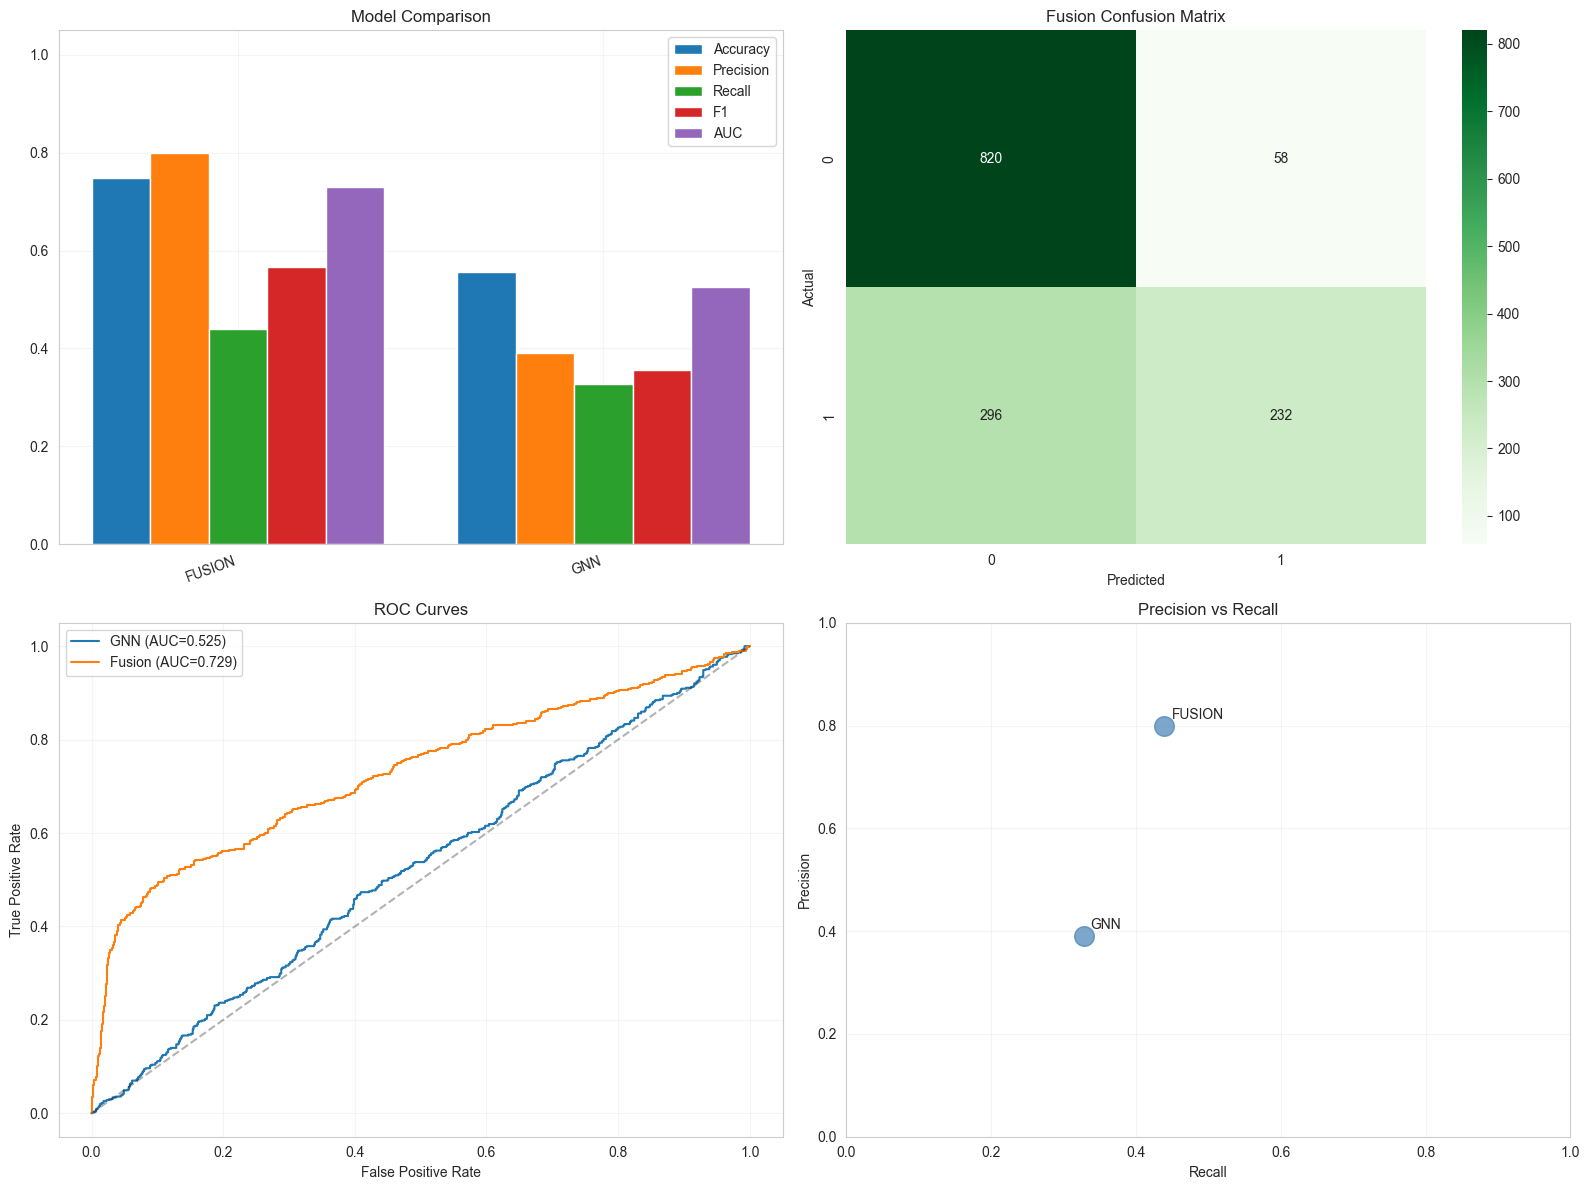

✅ Saved evaluation figure to C:\Users\youss\Downloads\Flag_finance\pipeline_output\complete_pipeline_evaluation.png


In [15]:
# Cell 15: Evaluation metrics and visualisations
comparison_df = pipeline.evaluate_predictions(fusion_test_labels, split_name='test')
comparison_df = comparison_df.sort_values('F1', ascending=False).reset_index(drop=True)
best_model = comparison_df.iloc[0]['Model']
best_f1 = comparison_df.iloc[0]['F1']
print(f"\n🏆 Best-performing model on test split: {best_model} (F1={best_f1:.4f})")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Bar plot of key metrics
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
x = np.arange(len(comparison_df))
width = 0.16
for i, metric in enumerate(metrics_to_plot):
    axes[0].bar(x + i * width, comparison_df[metric], width, label=metric)
axes[0].set_xticks(x + width * (len(metrics_to_plot) - 1) / 2)
axes[0].set_xticklabels(comparison_df['Model'], rotation=20, ha='right')
axes[0].set_ylim(0, 1.05)
axes[0].set_title('Model Comparison'); axes[0].legend(); axes[0].grid(alpha=0.2)

# Confusion matrix for fusion model
fusion_cm = confusion_matrix(fusion_test_labels, fusion_preds)
sns.heatmap(fusion_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Fusion Confusion Matrix')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('Actual')

# ROC curves (if GNN predictions available)
if gnn_probs is not None:
    gnn_fpr, gnn_tpr, _ = roc_curve(fusion_test_labels[: len(gnn_probs)], gnn_probs[: len(fusion_test_labels)])
    axes[2].plot(gnn_fpr, gnn_tpr, label=f'GNN (AUC={roc_auc_score(fusion_test_labels[: len(gnn_probs)], gnn_probs[: len(fusion_test_labels)]):.3f})')
fusion_fpr, fusion_tpr, _ = roc_curve(fusion_test_labels, fusion_probs)
axes[2].plot(fusion_fpr, fusion_tpr, label=f'Fusion (AUC={roc_auc_score(fusion_test_labels, fusion_probs):.3f})')
axes[2].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[2].set_title('ROC Curves'); axes[2].set_xlabel('False Positive Rate'); axes[2].set_ylabel('True Positive Rate'); axes[2].legend(); axes[2].grid(alpha=0.2)

# Precision-Recall scatter
axes[3].scatter(comparison_df['Recall'], comparison_df['Precision'], s=200, c='steelblue', alpha=0.7)
for _, row in comparison_df.iterrows():
    axes[3].annotate(row['Model'], (row['Recall'], row['Precision']), textcoords='offset points', xytext=(5, 5))
axes[3].set_xlim(0, 1); axes[3].set_ylim(0, 1)
axes[3].set_title('Precision vs Recall')
axes[3].set_xlabel('Recall'); axes[3].set_ylabel('Precision'); axes[3].grid(alpha=0.2)

plt.tight_layout()
viz_file = PIPELINE_OUTPUT / 'complete_pipeline_evaluation.png'
PIPELINE_OUTPUT.mkdir(parents=True, exist_ok=True)
plt.savefig(viz_file, dpi=150, bbox_inches='tight')
plt.show()
print(f'✅ Saved evaluation figure to {viz_file}')

## Sample Fraud Predictions with Explanations

In [16]:
# Cell 16: Inspect top fraud cases and attach template explanations
sample_explanations_file = OUTPUT_PATH / 'sample_explanations.json'
samples_file = PIPELINE_OUTPUT / 'sample_predictions.json'

n_samples = 5
fraud_indices = np.where(fusion_preds == 1)[0]
sample_predictions: List[Dict[str, object]] = []
sample_explanations: List[Dict[str, object]] = []

if len(fraud_indices) == 0:
    print('ℹ️ No fraud predictions generated by the fusion model.')
    sample_explanations_file.write_text(json.dumps(sample_explanations, indent=2), encoding='utf-8')
    with open(samples_file, 'w', encoding='utf-8') as f_out:
        json.dump(sample_predictions, f_out, indent=2)
else:
    order = np.argsort(fusion_probs[fraud_indices])[::-1]
    selected = fraud_indices[order[:n_samples]]
    print(f'\nAnalyzing top {len(selected)} high-confidence fraud predictions...')
    for idx in selected:
        record = {
            'sample_id': int(idx),
            'true_label': int(fusion_test_labels[idx]),
            'predicted_label': int(fusion_preds[idx]),
            'fraud_probability': float(fusion_probs[idx]),
            'status': 'CORRECT' if fusion_preds[idx] == fusion_test_labels[idx] else 'INCORRECT'
        }
        if gnn_preds is not None and idx < len(gnn_preds):
            record['gnn_prediction'] = int(gnn_preds[idx])
            if gnn_probs is not None and idx < len(gnn_probs):
                record['gnn_probability'] = float(gnn_probs[idx])
        if idx < len(df):
            record['explanation'] = template_explanation(
                df.iloc[idx].to_dict(),
                fusion_probs[idx],
                int(fusion_preds[idx])
            )
        else:
            record['explanation'] = f"Fraud probability: {fusion_probs[idx]:.2%}"
        sample_predictions.append(record)
        sample_explanations.append({
            'sample_id': record['sample_id'],
            'explanation': record['explanation'],
            'fraud_probability': record['fraud_probability'],
            'status': record['status']
        })
        print(f"Sample #{idx}: true={'FRAUD' if fusion_test_labels[idx] == 1 else 'LEGIT'} | pred={'FRAUD' if fusion_preds[idx] == 1 else 'LEGIT'} | prob={fusion_probs[idx]:.4f} | status={record['status']}")
        if 'gnn_probability' in record:
            print(f"   GNN probability: {record['gnn_probability']:.4f}")
        print('-' * 60)
    sample_explanations_file.write_text(json.dumps(sample_explanations, indent=2), encoding='utf-8')
    with open(samples_file, 'w', encoding='utf-8') as f_out:
        json.dump(sample_predictions, f_out, indent=2)
    print(f'✅ Saved sample explanations to {sample_explanations_file}')
    print(f'✅ Saved detailed predictions to {samples_file}')


Analyzing top 5 high-confidence fraud predictions...
Sample #47: true=FRAUD | pred=FRAUD | prob=0.9791 | status=CORRECT
   GNN probability: 0.5880
------------------------------------------------------------
Sample #25: true=FRAUD | pred=FRAUD | prob=0.9789 | status=CORRECT
   GNN probability: 0.3951
------------------------------------------------------------
Sample #852: true=FRAUD | pred=FRAUD | prob=0.9786 | status=CORRECT
   GNN probability: 0.3031
------------------------------------------------------------
Sample #1279: true=FRAUD | pred=FRAUD | prob=0.9777 | status=CORRECT
   GNN probability: 0.1367
------------------------------------------------------------
Sample #936: true=FRAUD | pred=FRAUD | prob=0.9771 | status=CORRECT
   GNN probability: 0.1371
------------------------------------------------------------
✅ Saved sample explanations to C:\Users\youss\Downloads\Flag_finance\rag_output\sample_explanations.json
✅ Saved detailed predictions to C:\Users\youss\Downloads\Flag_

## Persist Pipeline Results & Metadata

In [18]:
# Cell 17: Generate consolidated results artefacts
explanation_stats = {
    'total_samples': int(len(fusion_test_labels)),
    'fraud_predictions': int(fusion_preds.sum()),
    'legit_predictions': int((fusion_preds == 0).sum()),
    'avg_probability': float(np.mean(fusion_probs)),
    'max_probability': float(np.max(fusion_probs)),
    'min_probability': float(np.min(fusion_probs))
}

results_payload = {
    'system_info': {
        'vector_database': 'FAISS' if ('faiss_path' in globals() and faiss_path) else 'Not built',
        'embedding_model': 'sentence-transformers/all-MiniLM-L6-v2',
        'gnn_model_loaded': pipeline.gnn_model is not None,
        'lstm_model_loaded': pipeline.lstm_model is not None,
        'fusion_model_loaded': pipeline.fusion_model is not None
    },
    'performance': comparison_df.to_dict('records'),
    'best_model': {
        'name': best_model,
        'f1': float(best_f1)
    },
    'explanation_stats': explanation_stats,
    'output_files': {
        'evaluation_plot': str(viz_file),
        'sample_predictions': str(samples_file),
        'rag_sample_explanations': str(sample_explanations_file),
        'service_bundle': str(SERVICE_ROOT)
    }
}

results_file = PIPELINE_OUTPUT / 'rag_llm_results.json'
with open(results_file, 'w', encoding='utf-8') as f_out:
    json.dump(results_payload, f_out, indent=2)
print(f'✅ Saved results summary to {results_file}')

pipeline_report_path = pipeline.generate_report(PIPELINE_OUTPUT, additional_context={'comparison': comparison_df.to_dict('records')})

✅ Saved results summary to C:\Users\youss\Downloads\Flag_finance\pipeline_output\rag_llm_results.json
✅ Pipeline report saved to C:\Users\youss\Downloads\Flag_finance\pipeline_output\pipeline_report.json


## Save Auxiliary Assets & Deployment Checklist

In [23]:
# Cell 18: Persist predictions, comparison tables, and deployment checklist
predictions_payload = {name: {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in payload.items()} for name, payload in pipeline.predictions.items()}
predictions_file = PIPELINE_OUTPUT / 'all_predictions.pkl'
with open(predictions_file, 'wb') as f_out:
    pickle.dump(predictions_payload, f_out)
print(f'✅ Stored model predictions at {predictions_file}')

comparison_file = PIPELINE_OUTPUT / 'model_comparison.csv'
comparison_df.to_csv(comparison_file, index=False)
print(f'✅ Comparison table saved to {comparison_file}')

summary_text = f"""FLAG-FINANCE PIPELINE EXECUTION REPORT\n{'='*80}\n\nExecution Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\nBEST MODEL\n----------\nModel: {best_model}\nF1 Score: {best_f1:.4f}\nAccuracy: {comparison_df.iloc[0]['Accuracy']:.4f}\nPrecision: {comparison_df.iloc[0]['Precision']:.4f}\nRecall: {comparison_df.iloc[0]['Recall']:.4f}\nAUC: {comparison_df.iloc[0]['AUC']:.4f}\n\nFRAUD DETECTION PERFORMANCE\n---------------------------\nTotal Transactions Analyzed (fusion test): {len(fusion_test_labels)}\nFraud Predictions: {int(fusion_preds.sum())}\nDetection Rate (Recall): {recall_score(fusion_test_labels, fusion_preds):.2%}\n\nOUTPUT FILES\n------------\n  • Pipeline Report: {pipeline_report_path}\n  • Predictions: {predictions_file}\n  • Comparison Table: {comparison_file}\n  • Evaluation Plot: {viz_file}\n  • Sample Predictions: {samples_file}\n  • Service Bundle: {SERVICE_ROOT}\n\nNEXT STEPS\n----------\n1. Review sample predictions for qualitative validation\n2. Deploy the best fusion model via the exported FastAPI service\n3. Configure monitoring & alerting on fraud detection metrics\n4. Integrate RAG explanations into downstream dashboards\n5. Package pipeline into CI/CD workflow with Docker image\n{'='*80}\n"""
summary_file = PIPELINE_OUTPUT / 'pipeline_summary.txt'
summary_file.write_text(summary_text, encoding='utf-8')
print(f'✅ Summary report saved to {summary_file}')

deployment_checklist = {
    'models_loaded': {
        'gnn': bool(pipeline.gnn_model is not None),
        'lstm': bool(pipeline.lstm_model is not None),
        'fusion': bool(pipeline.fusion_model is not None)
    },
    'data_processed': {
        'graph_data': bool(pipeline.graph_data is not None),
        'embeddings_available': bool(fusion_data)
    },
    'predictions_complete': {
        'fusion': bool('fusion' in pipeline.predictions),
        'gnn': bool('gnn' in pipeline.predictions)
    },
    'performance_targets': {
        'f1_above_0_5': bool(float(best_f1) >= 0.5),
        'auc_above_0_7': bool(float(comparison_df.iloc[0]['AUC']) >= 0.7),
        'recall_above_0_6': bool(float(comparison_df.iloc[0]['Recall']) >= 0.6)
    }
}

checklist_file = PIPELINE_OUTPUT / 'deployment_checklist.json'
with open(checklist_file, 'w', encoding='utf-8') as f_out:
    json.dump(deployment_checklist, f_out, indent=2)
print(f'✅ Deployment checklist saved to {checklist_file}')

all_checks_passed = all(all(values.values()) for values in deployment_checklist.values())
if all_checks_passed:
    print('\n🎉 ALL CHECKS PASSED - READY FOR DEPLOYMENT!')
else:
    print('\n⚠️ Some checks failed - review checklist before deployment.')

✅ Stored model predictions at C:\Users\youss\Downloads\Flag_finance\pipeline_output\all_predictions.pkl
✅ Comparison table saved to C:\Users\youss\Downloads\Flag_finance\pipeline_output\model_comparison.csv
✅ Summary report saved to C:\Users\youss\Downloads\Flag_finance\pipeline_output\pipeline_summary.txt
✅ Deployment checklist saved to C:\Users\youss\Downloads\Flag_finance\pipeline_output\deployment_checklist.json

⚠️ Some checks failed - review checklist before deployment.
